In [1]:
from Bio import SeqIO
from gzip import open as gzopen
genome="/pasteur/homes/bli/Documents/Cecere_team/Genome_image/genomes/Yersinia_pestis.fna.gz"
#chrom="NC_003143.1"
chrom="NC_003131.1"
with gzopen(genome, "rt") as handle:
    records = dict((rec.id, rec) for rec in SeqIO.parse(handle, "fasta"))

[-15.0,
 -11.0,
 -4.0,
 -3.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0]

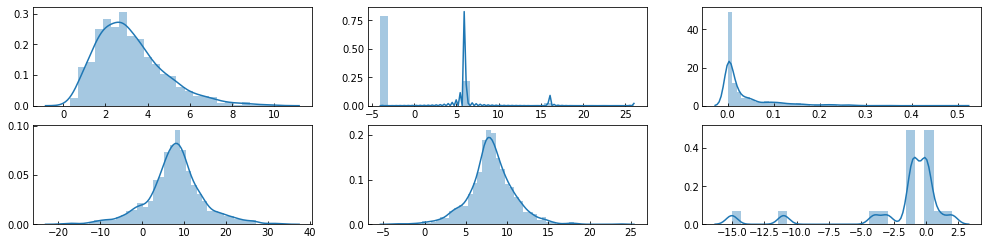

In [2]:
%matplotlib inline
import numpy as np
from seaborn import distplot
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3)
points = 0.5 * np.random.gamma(4, 1.6, 1000)
distplot(points, ax=axes[0, 0])

points = (10 * np.random.poisson(0.3, 1000)) - 4
distplot(points, ax=axes[0, 1])

points = np.random.beta(0.3, 8, 1000)
distplot(points, ax=axes[0, 2])

points = np.random.laplace(8, 5, 1000)
distplot(points, ax=axes[1, 0])

points = np.random.laplace(8, 2, 1000)
distplot(points, ax=axes[1, 1])

points = np.floor(np.random.standard_cauchy(20))
distplot(points, ax=axes[1, 2])

fig.set_figwidth(17)
sorted(points)

[-5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -3.0,
 -3.0,
 -2.0,
 -2.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 4.0,
 5.0,
 31.0]

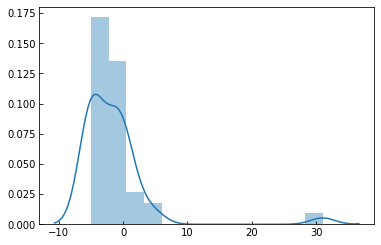

In [3]:
offsets = np.concatenate([5 * np.random.poisson(0.3, 20) - 5, np.floor(np.random.standard_cauchy(20))])
distplot(offsets)
sorted(offsets)

In [4]:
# forward small read
sf_start = 57327
sf_stop = 57348
sf = "\t".join((chrom, f"{sf_start}", f"{sf_stop}", "sf", ".", "+"))
# degradome reverse reads
dr_start_offsets = offsets

drs = list(map(
    "\t".join,
    [(chrom, f"{int(sf_start + dr_start_offset + 1 - dr_len)}", f"{int(sf_start + dr_start_offset + 1)}", f"dr{i}", ".", "-") for (
        i,
        (dr_start_offset, dr_len)) in enumerate(zip(dr_start_offsets, np.random.randint(33, 70, len(dr_start_offsets))))]))
#print(sf, *drs, sep="\n")

In [5]:
# reverse small read
sr_start = 57344
sr_stop = 57366
sr = "\t".join((chrom, f"{sr_start}", f"{sr_stop}", "sr", ".", "-"))
# degradome forward reads
df_start_offsets = [0 - offset for offset in offsets]

dfs = list(map(
    "\t".join,
    [(chrom, f"{int((sr_stop - 1) - df_start_offset)}", f"{int((sr_stop - 1) + df_len - df_start_offset)}", f"df{i}", ".", "+") for (
        i,
        (df_start_offset, df_len)) in enumerate(zip(df_start_offsets, np.random.randint(33, 70, len(df_start_offsets))))]))
#print(sr, *dfs, sep="\n")

In [6]:
from pybedtools import BedTool
import tempfile
with tempfile.NamedTemporaryFile(mode="w") as handle:
    SeqIO.write(records.values(), handle, "fasta")
    drs_fasta = BedTool("\n".join(drs), from_string=True).sequence(fi=handle.name)
    degradome_rev_revcompl = []
    with open(drs_fasta.seqfn) as in_fasta_handle:
        for record in SeqIO.parse(in_fasta_handle, "fasta"):
            record.seq = record.seq.reverse_complement()
            degradome_rev_revcompl.append(record)
    with open("degradome_rev.fa", "w") as out_fasta_handle:
        SeqIO.write(degradome_rev_revcompl, out_fasta_handle, "fasta")
    dfs_fasta = BedTool("\n".join(dfs), from_string=True).sequence(fi=handle.name)
    dfs_fasta.save_seqs("degradome_fwd.fa")
    #with open("degradome_fwd.fa", "w") as out_fasta_handle:
    #    SeqIO.write(degradome_rev_revcompl, out_fasta_handle, "fasta")
    #TODO: reverse-complement the antisense reads, write to file, map on genome, get bam file to test
    sf_fasta = BedTool(sf, from_string=True).sequence(fi=handle.name)
    sf_fasta.save_seqs("small_fwd.fa")
    sr_fasta = BedTool(sr, from_string=True).sequence(fi=handle.name)
    with open(sr_fasta.seqfn) as in_fasta_handle:
        record = SeqIO.read(in_fasta_handle, "fasta")
        record.seq = record.seq.reverse_complement()
    with open("small_rev.fa", "w") as out_fasta_handle:
        SeqIO.write(record, out_fasta_handle, "fasta")


index file /tmp/tmpuniqi03u.fai not found, generating...


In [7]:
!bowtie2-build --seed 123 /pasteur/homes/bli/Documents/Cecere_team/Genome_image/genomes/Yersinia_pestis.fna.gz Yersinia_pestis

Settings:
  Output files: "Yersinia_pestis.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 123
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  /pasteur/homes/bli/Documents/Cecere_team/Genome_image/genomes/Yersinia_pestis.fna.gz
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1207463
Using parameters --bmax 905598 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing

In [8]:
!cat small_fwd.fa small_rev.fa > to_map_small.fa
!cat degradome_rev.fa degradome_fwd.fa > to_map_degradome.fa

In [9]:
!bowtie2 --seed 123 -N 0 -i S,1,0.8 -f -x Yersinia_pestis -U to_map_small.fa -S mapped_small.sam

2 reads; of these:
  2 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    2 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


In [10]:
!bowtie2 --seed 123 -N 0 -i S,1,0.8 -f -x Yersinia_pestis -U to_map_degradome.fa -S mapped_degradome.sam

80 reads; of these:
  80 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    80 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


In [11]:
!sam2indexedbam.sh mapped_small.sam

In [12]:
!sam2indexedbam.sh mapped_degradome.sam

In [13]:
!time /pasteur/homes/bli/src/bioinfo_utils/Degradome-seq/degradome_metaprofile.py \
    -d mapped_degradome_sorted.bam -s mapped_small_sorted.bam \
    > distances_nofilter.txt

6.89user 1.80system 0:07.34elapsed 118%CPU (0avgtext+0avgdata 446144maxresident)k
0inputs+8outputs (0major+186307minor)pagefaults 0swaps


In [14]:
import pandas as pd
from collections import Counter
# To convert keys from float to int
from toolz import merge_with, keymap
expected_counts = pd.DataFrame.from_dict(
    keymap(
        int,
        merge_with(
            sum,
            (Counter(df_start_offsets), Counter(dr_start_offsets)))),
    orient="index")
expected_counts.index.name = "distance"
expected_counts.columns = ["counts"]
expected_counts.sort_index()

counts
distance        
-31            1
-5            18
-4             1
-3             2
-2             3
-1             9
 0            12
 1             9
 2             3
 3             2
 4             1
 5            18
 31            1

In [15]:
expected_counts.sum()

counts    80
dtype: int64

In [16]:
import pandas as pd
observed_counts = pd.read_table("distances_nofilter.txt", index_col=0)
observed_counts.sort_index()

count
distance       
-5           18
-4            1
-3            2
-2            3
-1            9
 0           12
 1            9
 2            3
 3            2
 4            1
 5           18

In [17]:
observed_counts.sum()

count    78
dtype: int64

In [18]:
!echo "rna103" > gene_list.txt

In [19]:
!time /pasteur/homes/bli/src/bioinfo_utils/Degradome-seq/degradome_metaprofile.py \
    -d mapped_degradome_sorted.bam -s mapped_small_sorted.bam \
    -g gene_list.txt -a Yersinia_pestis.gff -i "ID" \
    > distances_filtered.txt

7.64user 1.84system 0:08.15elapsed 116%CPU (0avgtext+0avgdata 447160maxresident)k
0inputs+8outputs (0major+192271minor)pagefaults 0swaps


In [20]:
observed_counts_filtered = pd.read_table("distances_filtered.txt", index_col=0)
observed_counts_filtered.sort_index()

count
distance       
-5           17
-3            2
-2            2
-1            7
 0            6
 1            2
 2            1
 4            1
 5            1

In [21]:
observed_counts_filtered.sum()

count    39
dtype: int64

In [32]:
from libhts import id_list_gtf2bed
from bam25prime import collapse_and_sort_bedtool
intervals = id_list_gtf2bed(
    ["rna103"],
    "Yersinia_pestis.gff",
    id_kwd="ID").sort().merge()
# Checking intersect
for bed in intervals:
    print(bed)
for (num_bed, bed) in enumerate(
        collapse_and_sort_bedtool(BedTool("\n".join(drs), from_string=True)),
        start=1):
    print(num_bed, bed, sep="\t", end="")
for (num_bed, bed) in enumerate(
        collapse_and_sort_bedtool(BedTool("\n".join(drs), from_string=True)).intersect(intervals),
        start=1):
    print(num_bed, bed, sep="\t", end="")

NC_003131.1	57241	57331

1	NC_003131.1	57322	57323	dr1	.	-
2	NC_003131.1	57322	57323	dr32	.	-
3	NC_003131.1	57322	57323	dr19	.	-
4	NC_003131.1	57322	57323	dr18	.	-
5	NC_003131.1	57322	57323	dr16	.	-
6	NC_003131.1	57322	57323	dr14	.	-
7	NC_003131.1	57322	57323	dr13	.	-
8	NC_003131.1	57322	57323	dr12	.	-
9	NC_003131.1	57322	57323	dr11	.	-
10	NC_003131.1	57322	57323	dr10	.	-
11	NC_003131.1	57322	57323	dr8	.	-
12	NC_003131.1	57322	57323	dr7	.	-
13	NC_003131.1	57322	57323	dr6	.	-
14	NC_003131.1	57322	57323	dr5	.	-
15	NC_003131.1	57322	57323	dr9	.	-
16	NC_003131.1	57322	57323	dr4	.	-
17	NC_003131.1	57322	57323	dr0	.	-
18	NC_003131.1	57324	57325	dr28	.	-
19	NC_003131.1	57324	57325	dr23	.	-
20	NC_003131.1	57325	57326	dr38	.	-
21	NC_003131.1	57325	57326	dr33	.	-
22	NC_003131.1	57326	57327	dr35	.	-
23	NC_003131.1	57326	57327	dr34	.	-
24	NC_003131.1	57326	57327	dr36	.	-
25	NC_003131.1	57326	57327	dr39	.	-
26	NC_003131.1	57326	57327	dr31	.	-
27	NC_003131.1	57326	57327	dr37	.	-
28	NC_003131.1	57326

In [33]:
# Checking intersect
for bed in intervals:
    print(bed)
for (num_bed, bed) in enumerate(
        collapse_and_sort_bedtool(BedTool("\n".join(dfs), from_string=True)),
        start=1):
    print(num_bed, bed, sep="\t", end="")
for (num_bed, bed) in enumerate(
        collapse_and_sort_bedtool(BedTool("\n".join(dfs), from_string=True)).intersect(intervals),
        start=1):
    print(num_bed, bed, sep="\t", end="")

NC_003131.1	57241	57331

1	NC_003131.1	57360	57361	df1	.	+
2	NC_003131.1	57360	57361	df32	.	+
3	NC_003131.1	57360	57361	df19	.	+
4	NC_003131.1	57360	57361	df18	.	+
5	NC_003131.1	57360	57361	df16	.	+
6	NC_003131.1	57360	57361	df14	.	+
7	NC_003131.1	57360	57361	df13	.	+
8	NC_003131.1	57360	57361	df12	.	+
9	NC_003131.1	57360	57361	df11	.	+
10	NC_003131.1	57360	57361	df10	.	+
11	NC_003131.1	57360	57361	df8	.	+
12	NC_003131.1	57360	57361	df7	.	+
13	NC_003131.1	57360	57361	df6	.	+
14	NC_003131.1	57360	57361	df5	.	+
15	NC_003131.1	57360	57361	df9	.	+
16	NC_003131.1	57360	57361	df4	.	+
17	NC_003131.1	57360	57361	df0	.	+
18	NC_003131.1	57362	57363	df28	.	+
19	NC_003131.1	57362	57363	df23	.	+
20	NC_003131.1	57363	57364	df38	.	+
21	NC_003131.1	57363	57364	df33	.	+
22	NC_003131.1	57364	57365	df35	.	+
23	NC_003131.1	57364	57365	df34	.	+
24	NC_003131.1	57364	57365	df36	.	+
25	NC_003131.1	57364	57365	df39	.	+
26	NC_003131.1	57364	57365	df31	.	+
27	NC_003131.1	57364	57365	df37	.	+
28	NC_003131.1	57364

In [23]:
intervals = id_list_gtf2bed(
    ["rna103"],
    "Yersinia_pestis.gff",
    id_kwd="ID").sort().merge()
for bed in intervals:
    print(bed)
for (num_bed, bed) in enumerate(BedTool("\n".join(dfs), from_string=True).intersect(intervals), start=1):
    print(num_bed, bed)

NC_003131.1	57241	57331



In [186]:
nofilter_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_nofilter_WT.txt", index_col="distance")
nofilter_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_nofilter_ADH.txt", index_col="distance")
filteredIP_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1_prot_si_supertargets_44hph_top200IP_WT.txt", index_col="distance")
filteredIP_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1_prot_si_supertargets_44hph_top200IP_ADH.txt", index_col="distance")
filteredlfc_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1_prot_si_supertargets_44hph_top200lfc_WT.txt", index_col="distance")
filteredlfc_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1_prot_si_supertargets_44hph_top200lfc_ADH.txt", index_col="distance")
filteredtargets_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1_prot_si_targets_44hph_WT.txt", index_col="distance")
filteredtargets_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1_prot_si_targets_44hph_ADH.txt", index_col="distance")
filteredup_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1ADH_vs_WT_all_alltypes_up_genes_WT.txt", index_col="distance")
filteredup_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1ADH_vs_WT_all_alltypes_up_genes_ADH.txt", index_col="distance")
filteredupnonsp_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1ADH_vs_WT_all_alltypes_up_genes_non_spermatogenic_WT.txt", index_col="distance")
filteredupnonsp_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1ADH_vs_WT_all_alltypes_up_genes_non_spermatogenic_ADH.txt", index_col="distance")
filteredupsp_WT = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1ADH_vs_WT_all_alltypes_up_genes_spermatogenic_WT.txt", index_col="distance")
filteredupsp_ADH = pd.read_table("/pasteur/entites/Mhe/bli/Degradome-seq_analyses/test_data/distances_csr1ADH_vs_WT_all_alltypes_up_genes_spermatogenic_ADH.txt", index_col="distance")

In [214]:
from libworkflows import texscape
distances = pd.concat((
    nofilter_WT, nofilter_ADH,
    filteredIP_WT, filteredIP_ADH,
    filteredlfc_WT, filteredlfc_ADH,
    filteredtargets_WT, filteredtargets_ADH,
    filteredup_WT, filteredup_ADH,
    filteredupnonsp_WT, filteredupnonsp_ADH,
    filteredupsp_WT, filteredupsp_ADH,
    ), axis=1)
distances.columns = list(map(texscape, [
    "nofilter_WT", "nofilter_ADH",
    "filteredIP_WT", "filteredIP_ADH",
    "filteredlfc_WT", "filteredlfc_ADH",
    "filteredtargets_WT", "filteredtargets_ADH",
    "filteredup_WT", "filteredup_ADH",
    "filteredupnonsp_WT", "filteredupnonsp_ADH",
    "filteredupsp_WT", "filteredupsp_ADH",
    ]))
distances

nofilter\_WT  nofilter\_ADH  filteredIP\_WT  filteredIP\_ADH  \
distance                                                                 
-15             551534         532151           99056           112615   
-14             565010         564522          148983           151709   
-13             504162         445269          122412           122447   
-12             543935         549965          100105           114636   
-11             545403         548625          122513           122617   
-10             501135         542725          103621           105995   
-9              608410         576065          128603           132715   
-8              569452         593395          141117           143138   
-7              425011         492641           95251           105109   
-6              451925         491970          102311           116199   
-5              634322         730586          157891           155451   
-4              260070         272214           77035            79926   
-3              575081         548665          140104           131357   
-2             1029757        1055139          252062           255333   
-1              283313         272151           71779            72373   
 0              694896         671011          152389           163137   
 1              800624         802382          233000           232044   
 2              677092         621752          156330           170535   
 3              675218         690247          145407           155727   
 4              912876         850010          228834           231467   
 5              732296         722764          267103           302873   
 6              692557         669923          174917           175452   
 7              952717         889264          210569           239374   
 8              526867         515987          122441           133820   
 9              870389         803994          203664           181725   
 10             864389         836068          164073           175605   
 11             709972         725726          203810           237685   
 12            1133534        1025639          186532           186804   
 13             930391         947301          201011           206310   
 14             758305         752070          172770           193821   
 15             890101         923922          223526           218015   
 16             845002         881879          218877           222770   
 17             632281         687848          167565           187201   
 18             763436         753385          190201           190937   
 19             815104         813288          217357           220288   
 20             544686         553325          125413           133078   
 21             651437         636848          192683           188218   
 22             859833         825703          193453           196994   
 23             573605         574576          154119           173263   
 24             610875         616730          175016           171492   
 25             703076         746488          163017           158500   

          filteredlfc\_WT  filteredlfc\_ADH  filteredtargets\_WT  \
distance                                                           
-15                102558             87244               486399   
-14                133056            124947               492600   
-13                142791            122129               442067   
-12                103048             89631               489053   
-11                131600            112511               506712   
-10                117683            105662               453869   
-9                 116300            108719               542364   
-8                 109111            106602               509993   
-7                 101234             96671               391183   
-6                  97320             97251               396388   
-5         

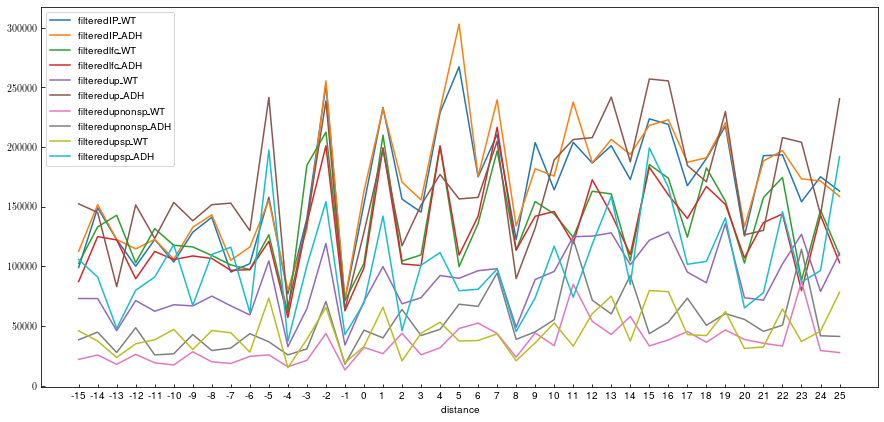

In [188]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 7))
ax.set_xticks(list(range(-15, 26)))
ax.set_xticklabels(map(str, range(-15, 26)))
distances.plot(ax=ax)

In [215]:
distances.sum(axis=0)

nofilter\_WT            27870079
nofilter\_ADH           27754213
filteredIP\_WT           6706920
filteredIP\_ADH          6968755
filteredlfc\_WT          5534881
filteredlfc\_ADH         5261170
filteredtargets\_WT     25172615
filteredtargets\_ADH    24621044
filteredup\_WT           3552869
filteredup\_ADH          6821443
filteredupnonsp\_WT      1440365
filteredupnonsp\_ADH     2129043
filteredupsp\_WT         1836088
filteredupsp\_ADH        4197563
dtype: int64

In [231]:
#fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 7))
#ax.set_xticks(list(range(-15, 26)))
#ax.set_xticklabels(map(str, range(-15, 26)))
#distances.div(distances.sum(axis=0)).plot(ax=ax)

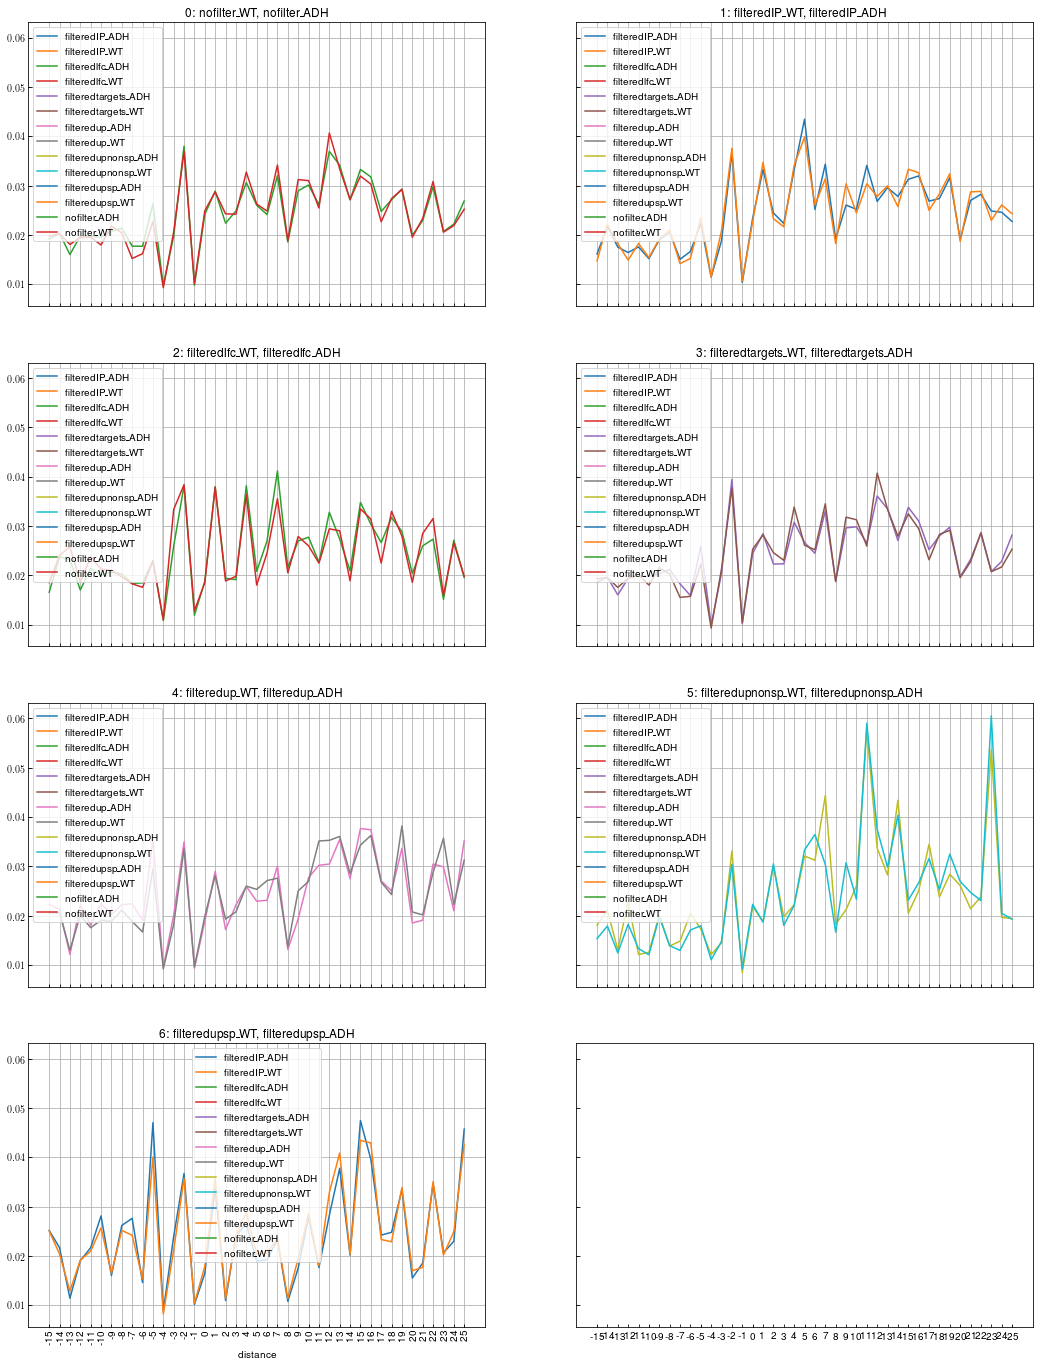

In [232]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(18, 24), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()[:-1]):
    distances.iloc[:, 2*i:2*(i+1)].div(distances.sum(axis=0)).plot(ax=ax)
    ax.set_xticks(list(range(-15, 26)))
    ax.set_xticklabels(map(str, range(-15, 26)), rotation=90)
    [WT_label, ADH_label] = distances.columns[2*i:2*(i+1)]
    ax.set_title(f"{i}: {WT_label}, {ADH_label}")
    ax.grid()

In [155]:
from itertools import dropwhile, groupby, takewhile
upstream = 10
downstream = 15
ref_pos = 20
positions = range(50)

In [236]:
67 * 2 * 

536

In [99]:
def in_range(position):
    return ref_pos - upstream <= position <= ref_pos + downstream
def out_range(position):
    return position < ref_pos - upstream or position > ref_pos + downstream
def is_upstream(position):
    return position < ref_pos - upstream
def not_downstream(position):
    return position <= ref_pos + downstream
def rel_pos(position):
    if position < ref_pos - upstream:
        return "before"
    elif position <= ref_pos + downstream:
        return "in"
    else:
        return "after"

In [100]:
for k, v in groupby(positions, rel_pos):
    print(k, list(v))

before [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
after [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [136]:
def extract_in(positions):
    for (group_key, group) in groupby(positions, rel_pos):
        if group_key == "in":
            return list(group)
%timeit real_positions = extract_in(positions)

9.5 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [129]:
for (k, v) in groupby(positions, in_range):
    print((k, list(v)))

(False, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
(True, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
(False, [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])


In [137]:
def extract_in(positions):
    for (group_key, group) in groupby(positions, in_range):
        if group_key:
            return list(group)
%timeit real_positions = extract_in(positions)

9.18 µs ± 188 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [125]:
%timeit list(filter(itemgetter(0), groupby(positions, in_range)))

12.4 µs ± 96.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [126]:
%timeit next(filter(itemgetter(0), groupby(positions, in_range)))

3.14 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [127]:
next(filter(itemgetter(0), groupby(positions, in_range)))

(True, <itertools._grouper at 0x7fe153d96f98>)

In [150]:
%timeit (_, group) = next(filter(itemgetter(0), groupby(positions, in_range)))

3.11 µs ± 254 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [151]:
(_, group) = next(filter(itemgetter(0), groupby(positions, in_range)))
%timeit real_positions = list(group)

347 ns ± 21.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [152]:
%timeit (_, group) = next(filter(itemgetter(0), groupby(positions, in_range))); real_positions = list(group)

9.72 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [147]:
%timeit real_positions = list(itemgetter(1)(next(filter(itemgetter(0), groupby(positions, in_range)))))

9.79 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [123]:
[(_, group)] = list(filter(itemgetter(0), groupby(positions, in_range)))
for elem in group:
    print(elem)

In [130]:
for (k, v) in filter(itemgetter(0), groupby(positions, in_range)):
    print((k, list(v)))

(True, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])


In [131]:
[(k, list(v)) for (k, v) in groupby(positions, in_range)]

[(False, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 (True,
  [10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35]),
 (False, [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])]

In [135]:
%timeit [real_positions] = [list(v) for (_, v) in filter(itemgetter(0), groupby(positions, in_range))]

13.1 µs ± 93.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [65]:
for k, v in groupby(positions, out_range):
    print(k, list(v))

True [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
False [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
True [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [63]:
from operator import itemgetter
for k, v in dropwhile(itemgetter(0), groupby(positions, out_range)):
    print(k, list(v))

False [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
True [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [156]:
def is_upstream(position):
    return position < ref_pos - upstream
def not_downstream(position):
    return position <= ref_pos + downstream
%timeit real_positions = list(takewhile(not_downstream, dropwhile(is_upstream, positions)))

6.7 µs ± 78 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [95]:
%timeit real_positions = [position for position in positions if in_range(position)]

12.1 µs ± 66 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [96]:
%timeit [position for position in positions if ref_pos - upstream <= position <= ref_pos + downstream]

7.62 µs ± 95 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [161]:
from pysam import AlignmentFile
bamfile = AlignmentFile("/extra2/Documents/Mhe/bli/Degradome-seq_analyses/results_csr1ADH_44hph/bowtie2/mapped_C_elegans/WT_44hph_1_on_C_elegans_sorted.bam", "rb")
for ali in bamfile.fetch("I", 9492629, 9494589):
    assert ali.reference_start >= 9492629

AssertionError: 